## Setup and Load Data

### 1. Setup Python Environment

This cell installs the required Python packages (`rpy2`) for running R code in this notebook.

In [1]:
import sys
try:
    import rpy2
except ImportError:
    !{sys.executable} -m pip install rpy2

This cell loads the required Python packages (`rpy2`) for running R code in this notebook.

In [2]:
%load_ext rpy2.ipython

### 2. Load Data

In [3]:
pip install "pandas[excel]" numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [5]:
data = pd.read_excel("data/personal_finance_dataset.xlsx", sheet_name = "datathon_finance")
dictionary = pd.read_excel("data/personal_finance_dataset.xlsx", sheet_name = "dictionary")

## Cleaning the Dataset

### 1. Inspecting the Dataset
We inspect the dataset using shape, head, info, and describe(). All 19 columns and 16,241 rows have non-null values, indicating there are no missing entries.

In [6]:
data.shape
data.head()
data.info()
data.describe()

data.isna().sum() # Check for missing values

<class 'pandas.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   PAGEMIEG  16241 non-null  int64
 1   PATTCRU   16241 non-null  int64
 2   PATTSITC  16241 non-null  int64
 3   PATTSKP   16241 non-null  int64
 4   PEDUCMIE  16241 non-null  int64
 5   PEFATINC  16241 non-null  int64
 6   PFMTYPG   16241 non-null  int64
 7   PFTENUR   16241 non-null  int64
 8   PLFFPTME  16241 non-null  int64
 9   PNBEARG   16241 non-null  int64
 10  PPVRES    16241 non-null  int64
 11  PWAPRVAL  16241 non-null  int64
 12  PWASTDEP  16241 non-null  int64
 13  PWATFS    16241 non-null  int64
 14  PWDPRMOR  16241 non-null  int64
 15  PWDSLOAN  16241 non-null  int64
 16  PWDSTCRD  16241 non-null  int64
 17  PWDSTLOC  16241 non-null  int64
 18  PWNETWPG  16241 non-null  int64
dtypes: int64(19)
memory usage: 2.4 MB


PAGEMIEG    0
PATTCRU     0
PATTSITC    0
PATTSKP     0
PEDUCMIE    0
PEFATINC    0
PFMTYPG     0
PFTENUR     0
PLFFPTME    0
PNBEARG     0
PPVRES      0
PWAPRVAL    0
PWASTDEP    0
PWATFS      0
PWDPRMOR    0
PWDSLOAN    0
PWDSTCRD    0
PWDSTLOC    0
PWNETWPG    0
dtype: int64

### 2. Filter Age Group
Keep only respondents aged 18–54 (PAGEMIEG 1–4).

In [7]:
# Remove the group ages not in 18-54
data = data[data['PAGEMIEG'].isin([1, 2, 3, 4])]

### 3. Classify Variables
We extract lists of binary, categorical, and continuous columns from the data dictionary.

In [8]:
# Find binary columns
binary_cols = dictionary[dictionary['Type'] == 'Binary']['Variable Name'].tolist()
print(binary_cols)

# Find categorial columns
categorial_cols = dictionary[dictionary['Type'] == 'Categorical']['Variable Name'].tolist()
print(categorial_cols)

# Find continuous columns
continuous_cols = dictionary[dictionary['Type'] == 'Continuous']['Variable Name'].tolist()
print(continuous_cols)

['PATTSKP']
['PAGEMIEG', 'PATTCRU', 'PATTSITC', 'PEDUCMIE', 'PFMTYPG', 'PFTENUR', 'PLFFPTME', 'PNBEARG', 'PPVRES']
['PEFATINC', 'PWAPRVAL', 'PWASTDEP', 'PWATFS', 'PWDPRMOR', 'PWDSLOAN', 'PWDSTCRD', 'PWDSTLOC', 'PWNETWPG']


### 4. Check for Unexpected Values
We check for outliers to decide what to do with those affected rows.

In [9]:
# Binary columns
for col in binary_cols:
    print(col, sorted(data[col].unique()))

PATTSKP [np.int64(1), np.int64(2)]


In [10]:
# Categorical columns
for col in categorial_cols:
    print(col, sorted(data[col].unique()))

PAGEMIEG [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
PATTCRU [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
PATTSITC [np.int64(1), np.int64(2), np.int64(3)]
PEDUCMIE [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(9)]
PFMTYPG [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(9)]
PFTENUR [np.int64(1), np.int64(2), np.int64(3)]
PLFFPTME [np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(9)]
PNBEARG [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(9)]
PPVRES [np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(24), np.int64(35), np.int64(46), np.int64(47), np.int64(48), np.int64(59)]


In [11]:
# Continuous columns
for col in continuous_cols:
    print(col)
    print(data[col].describe())
    print(sorted(data[col].unique())[:10], '...', sorted(data[col].unique())[-10:])
    print()

PEFATINC
count    6.349000e+03
mean     1.150532e+05
std      8.851525e+04
min     -1.682575e+06
25%      6.140000e+04
50%      1.004000e+05
75%      1.513750e+05
max      1.638300e+06
Name: PEFATINC, dtype: float64
[np.int64(-1682575), np.int64(-592550), np.int64(-277575), np.int64(-192800), np.int64(-142225), np.int64(-118650), np.int64(-87800), np.int64(-84600), np.int64(-57825), np.int64(-52875)] ... [np.int64(740475), np.int64(765200), np.int64(771500), np.int64(780425), np.int64(781650), np.int64(848550), np.int64(1168050), np.int64(1458150), np.int64(1608950), np.int64(1638300)]

PWAPRVAL
count    6.349000e+03
mean     5.185633e+05
std      6.847721e+05
min      0.000000e+00
25%      0.000000e+00
50%      3.500000e+05
75%      7.250000e+05
max      9.750000e+06
Name: PWAPRVAL, dtype: float64
[np.int64(0), np.int64(7000), np.int64(7250), np.int64(11000), np.int64(11500), np.int64(16000), np.int64(16500), np.int64(18000), np.int64(24000), np.int64(30000)] ... [np.int64(4800000), n

After inspecting each column, we see there are no unexpected values, which are given from the dictionary.

### 5. Add necessary variables to the dataset
We add or transform variables needed for analysis, such as:
- Encoding categorical and binary variables into numeric form suitable for clustering.
- Scaling continuous financial variables to ensure all features are on a comparable scale.
- Creating any derived variables that summarize or combine information, if relevant (e.g., total debt, net assets).

### 6. Saving the cleaned data

In [12]:
data.to_excel('data/cleaned_financial_data.xlsx', index=False)

## Identifying Key Predictors of Financial Stress and Stability

### Load Libraries in R

In [13]:
%%R
library(readxl)
library(tidyverse)

dataset <- read_excel("data/personal_finance_dataset.xlsx", sheet = "datathon_finance")
print(as.data.frame(head(dataset, 20), width = Inf))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
   PAGEMIEG PATTCRU PATTSITC PATTSKP PEDUCMIE PEFATINC PFMTYPG PFTENUR PLFFPTME
1         6       4        3       2        4   115525       4       1        3
2         7       4        3       2        9   121300       2       1        3
3         5       4        3       2        4    19175       2       1        3
4         6       3        3       2        4   147425       2       2        2
5         4       4        3       2        3    56750       1       3      

Performing forward stepwise selection to determine the best model to predict the net worth of an individual.

## Building a segmentation model using clustering to find distinct financial personas
Doing segmentation using k-means clustering.

### 1. Preprocessing Data

In [14]:
# Selecting relevant features for clustering
features = data[['PAGEMIEG', 'PWNETWPG']]

In [15]:
# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### 2. Make new data frame

### 3. Implementing and fitting the K-means Model

In [16]:
# Fitting K-means with the optimal number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)
labels = kmeans.labels_

In [17]:
plot_df = pd.DataFrame(scaled_features, columns=['PAGEMIEG', 'PWNETWPG'])
plot_df['Cluster'] = labels
print("Unique clusters found:", np.unique(labels))
print(plot_df['Cluster'].value_counts())

Unique clusters found: [0 1 2]
Cluster
1    2660
0    2061
2    1628
Name: count, dtype: int64


### 4. Evaluating the K-means Model

In [18]:
score = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.49602718964791603


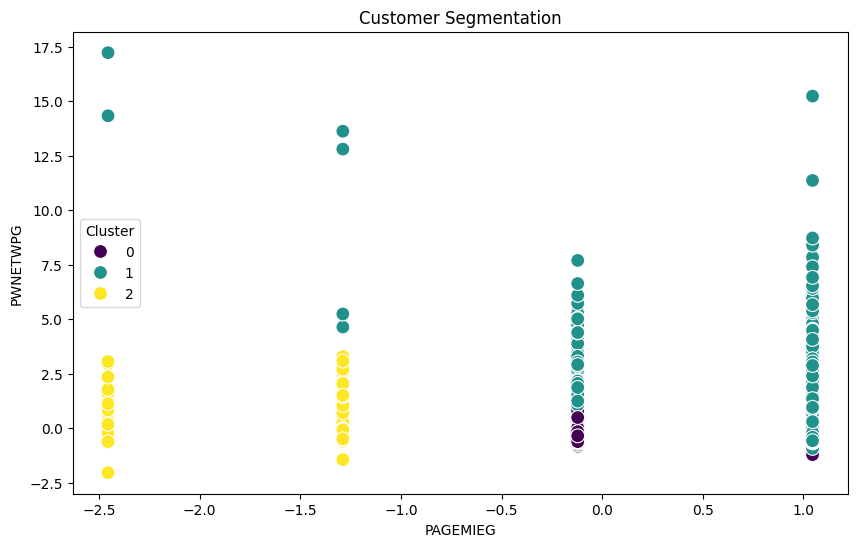

In [19]:

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,         # use the plotting DataFrame
    x='PAGEMIEG',         # feature 1
    y='PWNETWPG',         # feature 2
    hue='Cluster',        # color points by cluster
    palette='viridis',    # optional color map
    s=100                 # optional marker size
)
plt.title('Customer Segmentation')
plt.show()

### 5. Analyzing Segments

In [20]:
segment_analysis = plot_df.groupby('Cluster').mean()
print(segment_analysis)
print(kmeans.cluster_centers_)

         PAGEMIEG  PWNETWPG
Cluster                    
0       -0.121127 -0.260824
1        0.969517  0.388128
2       -1.430757 -0.303970
[[-0.1211271  -0.26082363]
 [ 0.96951692  0.38812812]
 [-1.43075679 -0.30397007]]
